In [39]:
#!pip install import-ipynb

In [40]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

In [41]:
def PCA_algorithm(data): 
    num_datatypes = data.select_dtypes(np.number)

    pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
    song_embedding = pca_pipeline.fit_transform(num_datatypes)
    return song_embedding

In [42]:
def KMeans_with_PCA_algorithm(song_embedding,n_clusters):
    kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    label = kmeans_pca.fit(song_embedding)
    centroids = kmeans_pca.cluster_centers_
    return label, centroids

In [43]:
def filter_based_on_segment(df_segm_pca_kmeans,segment_val,field1,field2):    
    #get list of songs with above song id
    #print(df_segm_pca_kmeans[df_segm_pca_kmeans['Segment K-means PCA']==segment_val].values)
    
    filtered_data_per_segment = df_segm_pca_kmeans[df_segm_pca_kmeans['Segment K-means PCA']==segment_val][[
        field1, field2 ,'com1','com2','Segment K-means PCA']]

    #save to csv file
    filtered_data_per_segment.to_csv('filtered_data_per_segment.csv')
    return filtered_data_per_segment

In [44]:
def filter_based_on_cluster_centroid(kmeans_pca, filtered_data_per_segment, segment_val, tracks):   
    #calculate distance based on cluster centroid
    scaled_data = kmeans_pca.transform(filtered_data_per_segment[['com1', 'com2']])
    scaled_song_center = kmeans_pca.transform(kmeans_pca.cluster_centers_[segment_val].reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')

    #sort based on distance
    index = list(np.argsort(distances)[0])
    rec_songs = filtered_data_per_segment.iloc[index]

    #recommend based on segment data
    # rec_songs = rec_songs[~rec_songs['name'].isin(filtered_data_per_segment['name'])]
    return rec_songs

In [45]:
def GetInPut(user,df_artist):
    inputArtist = pd.DataFrame(user)
    #Filtering out the movies by title
    Id = df_artist[df_artist['artist'].isin(inputArtist['artist'].tolist())]
    #Then merging it so we can get the movieId. It's implicitly merging it by title.
    inputArtist = pd.merge(Id, inputArtist)
    #Dropping information we won't use from the input dataframe
    #inputArtist = inputArtist.drop('year', 1)
    return inputArtist

In [46]:
def get_song_from_artist(artist, n_per_artist= 1):
    data_for_songs = pd.read_csv(r"datasets/data.csv")

    list_of_artists_songs = []
    for i in range(len(data_for_songs)):
        if artist in data_for_songs.loc[i, "artists"]:
            list_of_artists_songs.append(data_for_songs.loc[i, ["id", "artists", "name", "popularity"]])

    sorted_list_of_artists_songs = sorted(list_of_artists_songs, key=lambda d: d['popularity'], reverse=True)
    sorted_list_of_songs_only = np.array(sorted_list_of_artists_songs)
    unique_songs = np.unique(sorted_list_of_songs_only[:, 2])
    return unique_songs[:n_per_artist]


In [47]:
def get_song_data(song, spotify_data):
    
    """
    Gets the song data for a specifi song. The song argument takes the form of a dictionary with 
    key-value pairs for the name and release year of the song.
    """
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) ].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'])

In [48]:
def find_song(name):
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials
    from collections import defaultdict

    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="123wer4sf",
                                                               client_secret="wefrf852fd1s35s"))

    song_data = defaultdict()
    results = sp.search(q= 'track: {}'.format(name), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)


### ELBOW CHECK

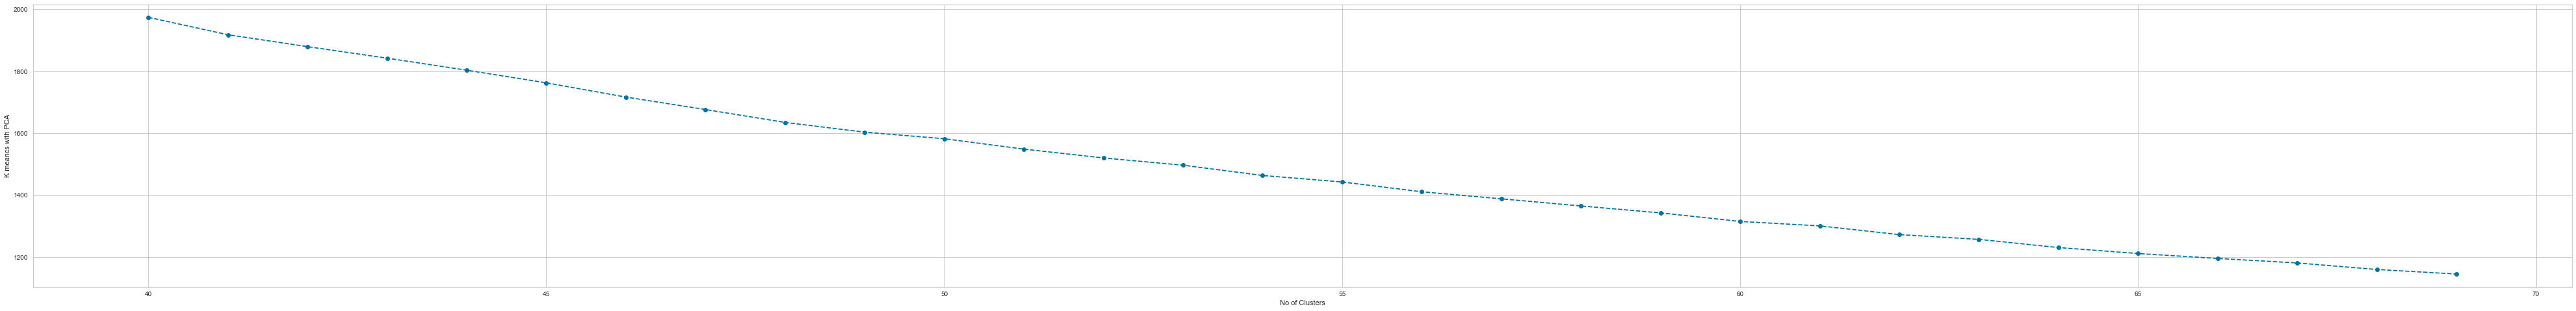

In [51]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import sklearn
# artist_data =  pd.read_csv(r"artist_data.csv")
# X = PCA_algorithm(artist_data)
# n_clusters = 70
#
# from sklearn.cluster import KMeans
# wcss = []
# for i in range(40, n_clusters):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)
#
# plt.figure(figsize = (n_clusters,8))
# plt.plot(range(40, n_clusters), wcss, marker = 'o', linestyle = '--')
# plt.xlabel('No of Clusters')
# plt.ylabel('K meancs with PCA')
# plt.show()